# Capstone Project - An escape from the City's gray
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Finding a place to relax and enjoy the nature while living in a crowded city can be hard sometimes. Such places called 'Escape Parks' can provide that "escape" needed while staying inside the city. The main focus of this project is to find an optimal location for an **Escape Park**. Specifically, this report will be targeted towards the local authorities of **London** in order to inform them about which neighborhood is of a greater need of a such park.

Since there are lots of parks in London we will try to detect **locations that are not already crowded with parks**. We are also particularly interested in **areas with no Escape Parks in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by the local authorities.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing parks in the neighborhood (any type of park)
* number of and distance to Escape Parks in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of parks and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of London center will be obtained using **Google Maps API geocoding** of well known London location (Charing Cross)

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around London city center.

Let's first find the latitude & longitude of London city center, using specific, well known address and Google Maps geocoding API.

In [1]:
from getkeys import get_gkey, get_fsqkey
google_api_key = get_gkey()
client_id , client_secret = get_fsqkey()

In [2]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = f'https://maps.googleapis.com/maps/api/geocode/json?key={google_api_key}&address={address}'
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = 'Charing Cross, London, United Kingdom'
london_center = get_coordinates(google_api_key, address)
latitude = london_center[0]
longitude = london_center[1]
print(f'The geograpical coordinate of {address} are {london_center}.')

The geograpical coordinate of Charing Cross, London, United Kingdom are [51.5090275, -0.1255016].


Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~6km from Charing Cross. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [3]:
import shapely.geometry

import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print(f'london center longitude={longitude}, latitude={latitude}.')
x, y = lonlat_to_xy(longitude, latitude)
print(f'london center UTM X={x}, Y={y}')
lo, la = xy_to_lonlat(x, y)
print(f'london center longitude={lo}, latitude={la}.')

Coordinate transformation check
-------------------------------
london center longitude=-0.1255016, latitude=51.5090275.
london center UTM X=-546825.0133404823, Y=5815713.712925149
london center longitude=-0.12550160000000424, latitude=51.5090275.


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [4]:
london_center_x, london_center_y = lonlat_to_xy(longitude, latitude) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = london_center_x - 6000
x_step = 600
y_min = london_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(london_center_x, london_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


Lets visualize the data we have gathered so far

In [5]:
import folium

map_london = folium.Map(location=[latitude,longitude], zoom_start=13)
folium.Marker([latitude,longitude], popup='Charing Cross').add_to(map_london)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='#2b0082', fill=False).add_to(map_london)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_london

In [6]:
def get_address(google_api_key, latitude, longitude, verbose=False):
    try:
        url = f'https://maps.googleapis.com/maps/api/geocode/json?key={google_api_key}&latlng={latitude},{longitude}'
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(google_api_key, london_center[0], london_center[1])

Now lets create a Pandas DataFrame with the above data and save it with pickle for later use.

In [7]:
import pickle
import pandas as pd

loaded = False
try:
    with open('locations.pkl', 'rb') as f:
        df_locations = pickle.load(f)
        addresses = [address for address in df_locations['Address']]
        loaded = True
except:
    pass

if loaded == False:
    print('Obtaining location addresses: ', end='')
    addresses = []
    for lat, lon in zip(latitudes, longitudes):
        address = get_address(google_api_key,lat, lon)
        if address is None:
            address = 'NO ADDRESS'
        address = address.replace(', United Kingdom', '') # We don't need country part of address
        address = address.replace(', England', '') # We don't need country part of address
        addresses.append(address)
        print(' .', end='')
    print(' done.')

    df_locations = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})
    df_locations.to_pickle('./locations.pkl')   

Let's print some addresses

In [8]:
addresses[100:110]

['Unnamed Road, Chelsea, London SW3 4SL, UK',
 '9 Gatliff Rd, London SW1W 8DF, UK',
 '166A Cambridge St, Pimlico, London SW1V 4QE, UK',
 '1 Drummond Gate, Pimlico, London SW1V 2QQ, UK',
 'Albert Embankment Prince Consort House (Stop SL), Vauxhall, London SE1 7GS, UK',
 "5 Beaufoy Walk, Prince's, London SE11 6HU, UK",
 "36 Gilbert Rd, Prince's, London SE11 4NL, UK",
 '8 Elephant Rd, London SE17 1AY, UK',
 '9 Deverell St, London SE1 4EW, UK',
 "1 Wood's Pl, Bermondsey, London SE1 3BS, UK"]

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on existing parks in each neighborhood.

We're interested in venues in 'Outdoors & Recreation category.

In [9]:
park_category = '4d4b7105d754a06377d81259'

# We included Botanical Gardens, Parks, Recreation Centers, State / Provincial Parks, Trails
escape_parks_categories = ["52e81612bcbc57f1066b7a22","4bf58dd8d48988d163941735","52e81612bcbc57f1066b7a26","4bf58dd8d48988d159941735","5bae9231bedf3950379f89d0"]

In [10]:
import json, requests

def is_apark(categories, specific_filter):
    park_words = ['park',"recreation","garden","trail","botanic"]
    park = False
    specific = False

    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in park_words:
            if r in category_name:
                park = True
        if (specific_filter) and (category_id in specific_filter):
            specific = True
            park = True
    return park, specific



def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', Sweden', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=350, limit=50):
    url = 'https://api.foursquare.com/v2/venues/explore'

    params = dict(
    client_id=client_id,
    client_secret=client_secret,
    v='20180724',
    ll=f'{lat},{lon}',
    limit=limit,
    radius=radius,
    categoryId=category
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)

    try:
        results = data['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
        pass
    return venues

In [11]:
import pickle

def get_parks(lats, lons):
    parks = {}
    escape_parks = {}
    location_parks = []
    location_parks_ = []


    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, park_category, client_id, client_secret)
        area_parks = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_park, is_escape = is_apark(venue_categories, escape_parks_categories)
            if is_park:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                park = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_escape, x, y, venue_categories)
                if venue_distance<=300:
                    area_parks.append(park)
                parks[venue_id] = park
                if is_escape:
                    escape_parks[venue_id] = park
        location_parks.append(area_parks)
        print(' .', end='')
    print(' done.')
    return parks, location_parks,escape_parks

# Try to load from local file system in case we did this before
parks = {}
location_parks = []
escape_parks = {}
loaded = False
try:
    with open('parks.pkl', 'rb') as f:
        parks = pickle.load(f)
    with open('escape_parks.pkl', 'rb') as f:
        escape_parks = pickle.load(f)
    with open('location_parks.pkl', 'rb') as f:
        location_parks = pickle.load(f)
    print('Park data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    parks,location_parks,escape_parks = get_parks(latitudes, longitudes)
    
    #Let's persists this in local file system
    with open('parks.pkl', 'wb') as f:
        pickle.dump(parks, f)
    with open('escape_parks.pkl', 'wb') as f:
        pickle.dump(escape_parks, f)
    with open('location_parks.pkl', 'wb') as f:
        pickle.dump(location_parks, f)

Park data loaded.


In [12]:
import numpy as np

print('Total number of Recreation parks:', len(parks))
print('Total number of Escape Parks:', len(escape_parks))
print('Average number of Recreation parks in a neighborhood:', np.array([len(r) for r in location_parks]).mean())
print('Percentage of Escape Parks: {:.2f}%'.format(len(escape_parks) / len(parks) * 100))

Total number of Recreation parks: 557
Total number of Escape Parks: 357
Average number of Recreation parks in a neighborhood: 1.4230769230769231
Percentage of Escape Parks: 64.09%


In [13]:
print('List of all Recration Parks')
print('-----------------------')
for r in list(parks.values())[:10]:
    print(r)
print('...')
print('Total:', len(parks))

List of all Recration Parks
-----------------------
('5040f5d4e4b09690b18c73c6', 'Brixton Oval', 51.45727845652839, -0.11563357316155502, 'United Kingdom', 150, True, -547352.1339639998, 5809863.389676164, [('Park', '4bf58dd8d48988d163941735')])
('5042097ee4b0235a81852e90', 'St Matthews Peace Gardens', 51.45775771888803, -0.11790799700270835, 'United Kingdom', 86, False, -547497.6607762516, 5809949.351899114, [('Garden', '4bf58dd8d48988d15a941735')])
('4e15b8a052b1b9e56442a3f3', 'Rush Common', 51.45777611317869, -0.1179396077526354, 'Brixton Hill, Brixton, Greater London, United Kingdom', 86, True, -547499.4098990277, 5809951.840606854, [('Park', '4bf58dd8d48988d163941735')])
('53fc6c81498eed608f057436', 'Milkwood Community Park', 51.46073880823568, -0.10081887245178223, 'Milkwood Road, London, Greater London, SE24 0HZ, United Kingdom', 40, True, -546250.9240754065, 5810029.463734958, [('Park', '4bf58dd8d48988d163941735')])
('4d9733b2c19fb60cbdf88f65', 'St Francis Park', 51.46215592344

In [14]:
print('List of Escape parks')
print('---------------------------')
for r in list(escape_parks.values())[:10]:
    print(r)
print('...')
print('Total:', len(escape_parks))

List of Escape parks
---------------------------
('5040f5d4e4b09690b18c73c6', 'Brixton Oval', 51.45727845652839, -0.11563357316155502, 'United Kingdom', 150, True, -547352.1339639998, 5809863.389676164, [('Park', '4bf58dd8d48988d163941735')])
('4e15b8a052b1b9e56442a3f3', 'Rush Common', 51.45777611317869, -0.1179396077526354, 'Brixton Hill, Brixton, Greater London, United Kingdom', 86, True, -547499.4098990277, 5809951.840606854, [('Park', '4bf58dd8d48988d163941735')])
('53fc6c81498eed608f057436', 'Milkwood Community Park', 51.46073880823568, -0.10081887245178223, 'Milkwood Road, London, Greater London, SE24 0HZ, United Kingdom', 40, True, -546250.9240754065, 5810029.463734958, [('Park', '4bf58dd8d48988d163941735')])
('4d9733b2c19fb60cbdf88f65', 'St Francis Park', 51.462155923445636, -0.0821077823638916, '1-28 Abbotswood Rd, East Dulwich, Greater London, SE2 2 8, United Kingdom', 125, True, -544928.9497891981, 5809913.8419260355, [('Park', '4bf58dd8d48988d163941735')])
('4ac518e9f964a52

In [15]:
print('Recration parks around location')
print('---------------------------')
for i in range(100, 110):
    rs = location_parks[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Recration parks around location
---------------------------
Restaurants around location 101: 
Restaurants around location 102: Ranelagh Gardens
Restaurants around location 103: 
Restaurants around location 104: Riverside Walk Gardens, Bessborough Gardens
Restaurants around location 105: 
Restaurants around location 106: Lambeth Walk Doorstep Green, Pedlar's Park, Kennington Park Square
Restaurants around location 107: Tibetan Peace Garden, West Square
Restaurants around location 108: Elephant Park, St Mary's Churchyard
Restaurants around location 109: Paraon Gardens, Paragon Gardens, Victory Community Park
Restaurants around location 110: 


In [16]:
map_london = folium.Map(location=london_center, zoom_start=13)
folium.Marker(london_center, popup='Charing Cross').add_to(map_london)
for park in parks.values():
    lat = park[2]; lon = park[3]
    is_escape = park[6]
    color = 'red' if is_escape else 'indigo'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_london)
map_london

In [17]:
location_parks_count = [len(park) for park in location_parks]
# df_locations.shape
df_locations['Recreation parks in area'] = location_parks_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_parks_count).mean())

df_locations.head(10)

Average number of restaurants in every area with radius=300m: 1.4230769230769231


,Address,Latitude,Longitude,X,Y,Distance from center,Recreation parks in area
0,"53 Leppoc Rd, Clapham Common, London SW4 9LS, UK",51.456111,-0.133714,-548625.01334,5.809998e+06,5992.495307,0
1,"75A Strathleven Rd, Brixton, London SW2 5JS, UK",51.457212,-0.125378,-548025.01334,5.809998e+06,5840.376700,0
2,"15 Brixton Hill, Brixton, London SW2 1RB, UK",51.458313,-0.117041,-547425.01334,5.809998e+06,5747.173218,3
3,"1 Leeson Rd, Brixton, London SE24 0PL, UK",51.459413,-0.108704,-546825.01334,5.809998e+06,5715.767665,0
4,"100A Lowden Rd, Herne Hill, London SE24 0BQ, UK",51.460513,-0.100366,-546225.01334,5.809998e+06,5747.173218,1
5,"171 Denmark Hill, Brixton, London SE5 8DX, UK",51.461612,-0.092028,-545625.01334,5.809998e+06,5840.376700,0
6,"East Dulwich Sainsbury's (Stop N), London SE22...",51.462710,-0.083689,-545025.01334,5.809998e+06,5992.495307,1
7,"Unnamed Road, Clapham Common, London SW4 9DE, UK",51.458967,-0.147746,-549525.01334,5.810518e+06,5855.766389,1
8,"Crescent Works, Crescent Lane, Clapham Common,...",51.460070,-0.139410,-548925.01334,5.810518e+06,5604.462508,2
9,"59 Haselrigge Rd, Ferndale, London SW4 7EN, UK",51.461171,-0.131073,-548325.01334,5.810518e+06,5408.326913,1


In [19]:
distances_to_escape_park = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for res in escape_parks.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_escape_park.append(min_distance)

df_locations['Distance to Escape park'] = distances_to_escape_park

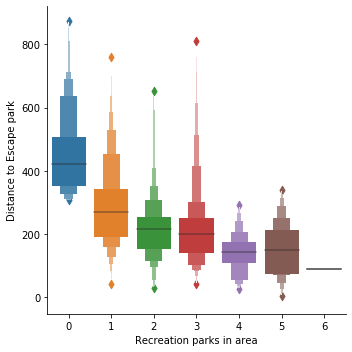

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
diamonds = sns.load_dataset("diamonds")
sns.catplot(x="Recreation parks in area", y="Distance to Escape park",kind="boxen", data=df_locations.sort_values("Recreation parks in area"))

In [20]:
parks_latlons = [[res[2], res[3]] for res in parks.values()]

escape_latlons = [[res[2], res[3]] for res in escape_parks.values()]

In [21]:
from folium import plugins
from folium.plugins import HeatMap

map_london = folium.Map(location=london_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_london) #cartodbpositron cartodbdark_matter
HeatMap(parks_latlons).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
folium.Circle(london_center, radius=1000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=2000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=3000, fill=False, color='white').add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [22]:
from folium import plugins
from folium.plugins import HeatMap

map_london = folium.Map(location=london_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_london) #cartodbpositron cartodbdark_matter
HeatMap(escape_latlons).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
folium.Circle(london_center, radius=1000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=2000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=3000, fill=False, color='white').add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [23]:
roi_x_min = london_center_x - 2000
roi_y_max = london_center_y + 1000
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_london = folium.Map(location=roi_center, zoom_start=14)
HeatMap(parks_latlons).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [24]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

2261 candidate neighborhood centers generated.


In [25]:
def count_parks_nearby(x, y, parks, radius=250):    
    count = 0
    for res in parks.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_park(x, y, parks):
    d_min = 100000
    for res in parks.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_park_counts = []
roi_escape_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_parks_nearby(x, y, parks, radius=250)
    roi_park_counts.append(count)
    distance = find_nearest_park(x, y, escape_parks)
    roi_escape_distances.append(distance)
print('done.')


Generating data on location candidates...done.


In [26]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Parks nearby':roi_park_counts,
                                 'Distance to Escape park':roi_escape_distances
                                 })

df_roi_locations.head(10)

,Latitude,Longitude,X,Y,Parks nearby,Distance to Escape park
0,51.475132,-0.107486,-546375.01334,5.811714e+06,2,166.342637
1,51.475315,-0.106096,-546275.01334,5.811714e+06,1,199.291422
2,51.474875,-0.115386,-546925.01334,5.811800e+06,0,398.936065
3,51.475059,-0.113996,-546825.01334,5.811800e+06,0,303.649773
4,51.475242,-0.112606,-546725.01334,5.811800e+06,1,212.735481
5,51.475425,-0.111216,-546625.01334,5.811800e+06,1,135.312915
6,51.475609,-0.109826,-546525.01334,5.811800e+06,1,106.596366
7,51.475792,-0.108436,-546425.01334,5.811800e+06,2,156.256153
8,51.475976,-0.107045,-546325.01334,5.811800e+06,2,137.732085
9,51.476159,-0.105655,-546225.01334,5.811800e+06,1,111.257107


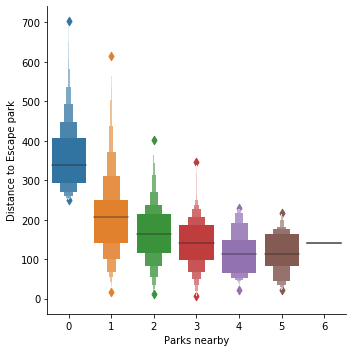

In [42]:
diamonds = sns.load_dataset("diamonds")
sns.catplot(x="Parks nearby", y="Distance to Escape park",kind="boxen", data=df_roi_locations.sort_values("Parks nearby"))

In [27]:
good_park_count = np.array((df_roi_locations['Parks nearby']<=1))
print('Locations with no more than one park nearby:', good_park_count.sum())

good_esc_distance = np.array(df_roi_locations['Distance to Escape park']>=300)
print('Locations with no Escape parks within 250m:', good_esc_distance.sum())

good_locations = np.logical_and(good_park_count, good_esc_distance) 
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]

Locations with no more than one park nearby: 1438
Locations with no Escape parks within 250m: 620
Locations with both conditions met: 597


In [45]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_london = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_london)
HeatMap(parks_latlons).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='#2E84D5', fill=True, fill_color='#2E84D5', fill_opacity=1).add_to(map_london) 
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [46]:
map_london = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='#2E84D5', fill=True, fill_color='#2E84D5', fill_opacity=1).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [56]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_london = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_london)
HeatMap(parks_latlons).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_london)
folium.Marker(london_center).add_to(map_london)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='red', fill=True, fill_opacity=0.25).add_to(map_london) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='#002bff', fill=True, fill_color='#002bff', fill_opacity=1).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [59]:
map_london = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(london_center).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='#002bff', fill=True, fill_color='#002bff', fill_opacity=1).add_to(map_london)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='red', fill=False).add_to(map_london) 
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [32]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(google_api_key, lat, lon).replace(', Germany', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, london_center_x, london_center_y)
    print('{}{} => {:.1f}km from Alexanderplatz'.format(addr, ' '*(50-len(addr)), d/1000))
    

Addresses of centers of areas recommended for further analysis

102 Shoe Ln, London EC4A 2BH, UK                   => 1.5km from Alexanderplatz
28 St Oswald's Pl, Vauxhall, London SE11 5JE, UK   => 2.5km from Alexanderplatz
65 Buckingham Gate, Westminster, London SW1E 6AS, UK => 1.4km from Alexanderplatz
Sumner Buildings, Sumner St, London SE1 9JY, UK    => 2.1km from Alexanderplatz
56 Churchill Gardens Roads, Pimlico, London SW1V 3JD, UK => 2.8km from Alexanderplatz
94 Swan Mead, London SE1 4SU, UK                   => 3.4km from Alexanderplatz
Lifeboat Pier, Victoria Embankment, London WC2R 2PP, UK => 0.6km from Alexanderplatz
1 Spring Gardens, St. James's, London SW1A 2BB, UK => 0.3km from Alexanderplatz
Cornwall Square, Kennings Way, Prince's, London SE11 4JP, UK => 2.6km from Alexanderplatz
270-272 Bethwin Rd, London SE5 0YW, UK             => 3.8km from Alexanderplatz
Verenigd Koninkrijk, Mayfair, London W1S 3ES, UK   => 1.0km from Alexanderplatz
61B Clapham Rd, Oval, London SW9 

In [62]:
map_london = folium.Map(location=roi_center, zoom_start=14)
folium.Circle(london_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_london)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_london) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_london)
map_london